In [1]:
# importing libraries
import cv2
import numpy as np
import matplotlib as mp
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import pickle
from matplotlib.path import Path
import matplotlib.patches as patches

## Helper Methods

This section include methods for sobel and all other action required

In [2]:
# appliying direction gradient on the image in x-axis
def performSobelX(image, sobel_kernal=3):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernal)
    
# appliying direction gradient on the image in y-axis
def performSobelY(image, sobel_kernal=3):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernal)

In [3]:
# applying the threshold on directional gradient
def performSobelGradientThreshold(image, axis='x', sobel_kernal=3, min_thresh=10, max_thresh=100):
    
    if axis is 'x':
        abs_sobel = np.absolute(performSobelX(image, sobel_kernal))
    else:
        abs_sobel = np.absolute(performSobelY(image, sobel_kernal))
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    s_binary = np.zeros_like(scaled_sobel)
    s_binary[(scaled_sobel >= min_thresh) & (scaled_sobel < max_thresh)] = 1
    
    return s_binary

In [4]:
# applying the threshold on the magnitude of the gradient
def performGradientMagnitudeThreshold(image, axis='x', sobel_kernal=3, mag_thresh=(0,255)):

    gradmag = None
    if axis is 'x':
        sobelx = performSobelX(image, sobel_kernal)
        gradmag = np.sqrt(sobelx**2)
    elif axis is 'y':
        sobely = performSobelY(image, sobel_kernal)
        gradmag = np.sqrt(sobely**2)
    elif axis is 'xy':
        sobelx = performSobelX(image)
        sobely = performSobelY(image)
        gradmag = np.sqrt(sobelx**2 + sobely**2)
    else:
        return null
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output
    
# applying threshold on the direction of the gradient
def performGradientDirectionThreshold(image, sobel_kernal=3, dir_thresh=(0, np.pi/2)):
    
    sobelx = performSobelX(image, sobel_kernal)
    sobley = performSobelY(image, sobel_kernal)
    
    absgraddir = np.arctan(np.absolute(sobely), np.absolute(sobelx))
    binary_img = np.zeros_like(absgraddir)
    binary_img[(absgraddir >= dir_thresh[0]) & (absgraddir < dir_thresh[1])] = 1
    
    return binary_img

In [5]:
# ploting two image side by side
def plot_images(img1, img2, title1, title2):
    plt.clf()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1, cmap='gray')
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

In [6]:
# method to return the#age, thresh=(0,255)):
def performHLSThreshold(image, thresh=(0, 255)):
    hls_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s = hls_img[:,:,2]
    output = np.zeros_like(s)
    output[(s > thresh[0]) & (s <= thresh[1])] = 1
    return output

In [7]:
def cal_undistort(orig_img, objpoints, imgpoints):
    gray_img = cv2.cvtColor(orig_img, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_img.shape[::-1], None, None)
    undist = cv2.undistort(orig_img, mtx, dist, None, mtx)
    return undist

In [8]:
# img_binary is supposed to be the final output after applying all the thresholding
# like color, gradient, etc on the image
def performPerspectiveTransform(img_binary, src_points, dst_points):
    img_size = (img_binary.shape[1], img_binary.shape[0])
    # take the src and dst points and calculate the perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img_binary, M, img_size)
    return warped

In [9]:
# implementing sliding window algo and fitting a polynomial
def laneDetectionUsingSlidingWindowsSearch():
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='red')
    plt.plot(right_fitx, ploty, color='red')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.imshow(warped, cmap='gray')
    plt.show()
    
    return ploty, left_fit, right_fit, left_fitx, right_fitx

In [10]:
def findLaneCurvatur(ploty, left_fit, right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)

In [19]:
# this method will take the lane image and return the image with lane area, curvature and offset from center marked
def findAndPlotLaneLines(image, obj_points, img_points, sobel_kernal=3, s_thresh=(0,255)):
    # 1. undistort the images
    undistored = cal_undistort(image, objpoints=obj_points, imgpoints=img_points)
    # 2. color thresholding with s-channel
    s_channel_binary = performHLSThreshold(undistored, thresh=s_thresh)
    # 3. perform various thresholding on the image
    # 3.a. sobelx thresholding
    sobelx = performSobelX(undistored, sobel_kernal)
    sobely = performSobelY(undistored, sobel_kernal)
    # 3.b. gradient magnitude thresholding
    
    # 3.c. gradient direction thresholding
    # 4. create a combined binary of all above thresholding
    all_combined = np.zeros_like(undistored)
    all_combined[(sobelx == 1) & (s_channel_binary == 1)] = 1
    # 5. perform perspective transform
    # 6. increase the hot points in the image
    # 7. perform sliding windows search algorithm for finding lane lines and fitting a polygon
    # 8. mark the area of lane lines
    # 9. undistort the image back to starting perspective and return
    plt.imshow(sobelx, cmap='gray')
    plt.show()

## Implementing above pipeline for lane images

In [12]:
# load the image and object points from disk. This data has been saved after
# calibrating it over given chessboard images
# Please refer to **p4_chessboard_image_processing.ipynb** for camera calibration code
obj_points = []
img_points = []
with open('obj_img_points.pickle', 'rb') as handle:
    a = pickle.load(handle)
    obj_points = a['objpoints']
    img_points = a['imgpoints']

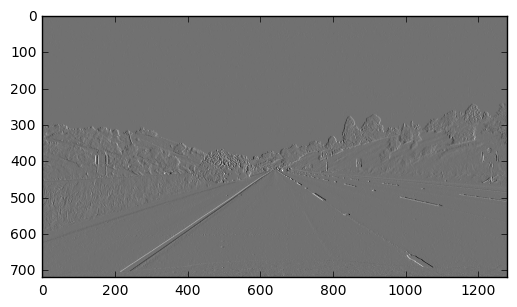

In [20]:
sl1_img = mpimg.imread('test_images\\straight_lines1.jpg')
sobel_kernal = 3
findAndPlotLaneLines(sl1_img, obj_points=obj_points, img_points=img_points, s_thresh=(70,255))
